# SCS 3546 Deep Learning Week 4 

# Deep Computer Vision

## Learning Outcome

In this module, we move beyond using CNN for Image Classification and introduce more advanced networks to address some important Computer Vision tasks. This topic deserves one complete course by itself, but we will only dive into two of the comon tasks: Object Detection and Instance Segmentation. The concepts introduced in this module will help you to read and understand other networks designed for computer vision tasks. 



## Topics
- [Introduction to Computer Vision](#s1)
- [Transfer Learning and Visual Feature Extraction](#s2)
    - [Visual Feature Extraction](#s2.1)
    - [When and How to Fine-tune](#s2.2)
    - [Practical Notes](#s2.3)
    - [Transfer Learning & Fine-tuning in Keras/Tensorflow](#s2.4)
- [Classification + Localization](#s3)
    - [Training & Evaluation](#s3.1)
- [Object Detection](#s4)
    - [Sliding Window Approach](#s4.1)
    - [Single Shot Detectors](#s4.8)
    - [YOLO](#s4.9)
    - [SSD](#s4.10)
- [Semantic Segmentation](#s5)
    - [Sliding Window Approach](#s5.1)
    - [Fully Convolutional Networks (FCN) for Semantic Segmentation](#s5.2)
    - [U-Net](#s5.3)
    - [Real-time Semantic Segmentation](#s5.4)
- [Region Proposals (Detection, Instance Segmentation)](#s4.2)
    - [R-CNN](#s4.3)
    - [Fast R-CNN](#s4.4)
    - [Faster R-CNN](#s4.5)
    - [Mask R-CNN (Object Detection + Instance Segmentation)](#s4.6)
    - [Demo: Mask R-CNN](#s4.7)
    - [Speed / Accuracy Comparison of Object Detectors](#s4.11)
    - [Impact of Deep Learning on Object Detection](#s4.12)
    - [Demo: Tensorflow Object Detection API](#s4.13)
- [Next Week](#s6)
- [References](#s7)


<a id="s1"></a>
# Introduction to Computer Vision

__Computer vision__ is an interdisciplinary field that deals with how computers can be made to gain high-level understanding from digital images or videos. 

__From the perspective of engineering__, it seeks to automate tasks that the human visual system can do. __Computer vision__ is concerned with the automatic extraction, analysis and understanding of useful information from a single image or a sequence of images. It involves the development of a theoretical and algorithmic basis to achieve automatic visual understanding.

__As a scientific discipline__, computer vision is concerned with the theory behind artificial systems that extract information from images. The image data can take many forms, such as video sequences, views from multiple cameras, or multi-dimensional data from a medical scanner.

__As a technological discipline__, computer vision seeks to apply its theories and models for the construction of computer vision systems.

Some of the common tasks in computer vision are as follows:

- Image Classification
- Classification + Localization
- Object Detection
- Instance Segmentation
- Semantic Segmentation
- Face Detection
- Image Captioning
- Action Detection in Videos
- Object Tracking in Videos
- and many more

Computer vision scientists have worked on the above tasks for decades and lots of mothods have been develped. However, the recent advnces in deep neural networks has brought much more success to this descipline than ever. Traditionally, scientists were relying on extracting manual features from images or videos to understand them or to extract useful information. But nowdays the features exctracted using Convolutional Neural Networks have revouloutionized this field. 

__Image Classification__ using different __CNN__ architectures was discussed in details in the previous module. In this module, we will move beyond classification and introduce the new methods and algorithms for two other common computer vision tasks using deep neural networks (DNNs). We will focus on object detection and image segmentation to introduce some common deep learning techniques used in computer vision.      

Before diving into details of each task, we will need to discuss the concept of Transfer Learning and Visual Feature Extraction using DNNs  

<img src="https://drive.google.com/uc?id=1eVRmntqxmH-gs8F2FGCtKowDW11IHJJn">
<br><center>Source: Fei-Fei Li, J. Johnson, s. Yeung, Convolutional Neural Networks for Visual Recognition, Spring 2018</center>

<img src="https://cdn-images-1.medium.com/max/1600/1*vK-ik3SDEUhhPbE4-nzgmQ.png">
Source: <a href="https://medium.com/geoai/integrating-deep-learning-with-gis-70e7c5aa9dfe">Integrating Deep Learning with GIS</a>

<a id="s3"></a>
## Classification + Localization

The next natural step after image classification is to locate the object in the picture. The following image shows the difference between __Image Classification__ and and __Classification + Localization__. As shown in the image, in the latter, we locate the object by estimating the coordinates of a rectangular bounding box around the object.   

<center><img src="https://drive.google.com/uc?id=10gv7yTFRLPoWNg9cYMiIRPr8k66VXrxf" >
<br>L.A. Santos, GitBooks: Artificila Intelligence</center>

Estimating the coordinates of the bounding box can be considered as a __Regression__ task with four outputs (x, y, w, h). The following image shows a candidate architecture to do both classification and regression tasks in parallel. The convolutional layers are shared and their output (feature map) is fed to two fully connected heads for classification and regression tasks. 

<img src="https://drive.google.com/uc?id=1JvySTSdsQ4MzmUsyEgFNnzQuNqNKL5a-" >
<br><center>Source: Fei-Fei Li, J. Johnson, s. Yeung, Convolutional Neural Networks for Visual Recognition, Spring 2018</center>

To evaluate the performance of the model, we need to measure the performance of both classifier and the regressor. Classification performance is measured the standard way that we have already discussed. But to measure the accuracy of the predicted bounding boxes, we need to introduce the concept of __Intersection of Union (IoU)__. The following images show how IOU is calculated and what different levels of IOU mean. The total accuracy will be defined as the means of all IoUs for all test images. 

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing import image
import matplotlib.patches as patches
import matplotlib.pyplot as plt

2021-07-28 20:04:29.970569: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [85]:
# Construct a tf.data.Dataset
ds_train = tfds.load('voc/2012', split='train', shuffle_files=True)
ds_test, ds_validation = tfds.load('voc', split=['test','validation'], shuffle_files=True)

In [86]:
# for example in ds_test.take(1):
#     print(example)

In [87]:
for example in ds_train.take(1):
  print(example.keys())

dict_keys(['image', 'image/filename', 'labels', 'labels_no_difficult', 'objects'])


(375, 500, 3) tf.Tensor(0, shape=(), dtype=int64) tf.Tensor([0.20266667 0.036      0.8        0.992     ], shape=(4,), dtype=float32)
(500, 375, 3) tf.Tensor(13, shape=(), dtype=int64) tf.Tensor([0.672      0.25866666 0.938      0.744     ], shape=(4,), dtype=float32)
(375, 500, 3) tf.Tensor(18, shape=(), dtype=int64) tf.Tensor([0.00266667 0.002      0.54933333 0.528     ], shape=(4,), dtype=float32)
(500, 401, 3) tf.Tensor(8, shape=(), dtype=int64) tf.Tensor([0.002      0.5311721  0.296      0.77306736], shape=(4,), dtype=float32)
(375, 500, 3) tf.Tensor(1, shape=(), dtype=int64) tf.Tensor([0.00266667 0.056      1.         1.        ], shape=(4,), dtype=float32)
(500, 375, 3) tf.Tensor(13, shape=(), dtype=int64) tf.Tensor([0.23       0.21333334 0.89       0.632     ], shape=(4,), dtype=float32)
(500, 333, 3) tf.Tensor(15, shape=(), dtype=int64) tf.Tensor([0.002    0.003003 1.       1.      ], shape=(4,), dtype=float32)
(334, 500, 3) tf.Tensor(1, shape=(), dtype=int64) tf.Tensor([0.002

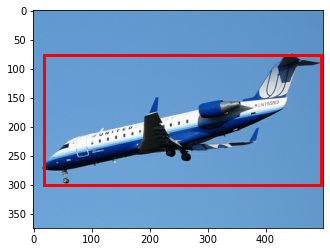

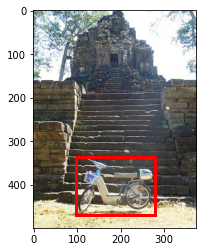

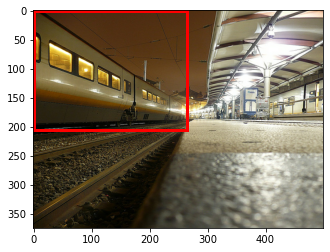

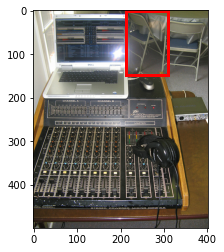

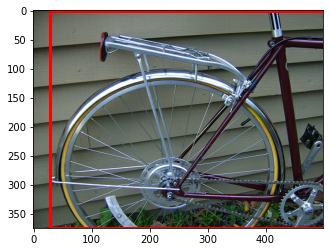

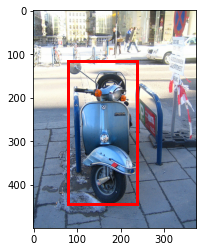

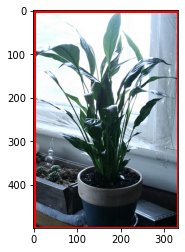

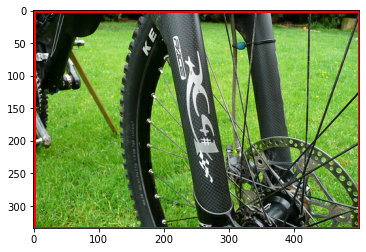

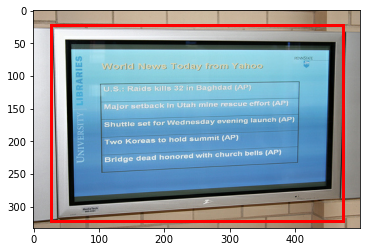

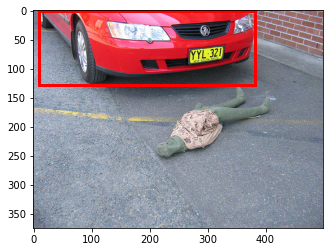

In [88]:


for t in ds_train.take(10).map(lambda x: (x['image'], x['objects']['label'][0], x['objects']['bbox'][0])):
  image_sample,label,box= t
  print(image_sample.shape, label, box)

  height = image_sample.shape[1]
  width = image_sample.shape[0]
  top_y = box[0]* width
  top_x = box[1]* height
  height_bbox = (box[2] - box[0] ) * width
  width_bbox = (box[3] - box[1]) * height

  fig,ax = plt.subplots(1)

  imgplot = ax.imshow(image.array_to_img(image_sample))
  rect = patches.Rectangle((top_x,top_y),width_bbox , height_bbox  ,linewidth=3,edgecolor='r',facecolor='none')
  # Add the patch to the Axes
  ax.add_patch(rect)


(300, 300, 3) tf.Tensor(7, shape=(), dtype=int64) tf.Tensor([0.13855422 0.348      0.92771083 0.78      ], shape=(4,), dtype=float32)


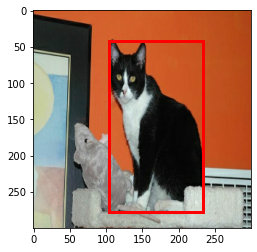

In [91]:
for t in ds_test.take(1).map(lambda x: (tf.image.resize(x['image'], [300,300]), x['objects']['label'][0], x['objects']['bbox'][0])):  
  image_sample,label,box= t
  print(image_sample.shape, label, box)

  height = image_sample.shape[1]
  width = image_sample.shape[0]
  top_y = box[0]* width
  top_x = box[1]* height
  height_bbox = (box[2] - box[0] ) * width
  width_bbox = (box[3] - box[1]) * height

  fig,ax = plt.subplots(1)

  # imgplot = ax.imshow(tf.image.draw_bounding_boxes(img, boxes, colors)[0])
  imgplot = ax.imshow(image.array_to_img(image_sample))
  rect = patches.Rectangle((top_x,top_y),width_bbox , height_bbox  ,linewidth=3,edgecolor='r',facecolor='none')
  # Add the patch to the Axes
  ax.add_patch(rect)



In [92]:
ds_train_image = ds_train.map(lambda a: (tf.image.resize(a['image'], [300,300]), (a['objects']['label'][0], a['objects']['bbox'][0]))).batch(32)
ds_test_image = ds_test.map(lambda a: (tf.image.resize(a['image'], [300,300]), (a['objects']['label'][0], a['objects']['bbox'][0]))).batch(32)
ds_validation_image = ds_validation.map(lambda a: (tf.image.resize(a['image'], [300,300]), (a['objects']['label'][0], a['objects']['bbox'][0])))

In [123]:
base_model = tf.keras.applications.Xception(weights="imagenet", include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
avg = tf.keras.layers.Dense(200, activation="relu")(avg)

In [124]:
n_classes = 20
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.00001)

In [125]:
class_output = tf.keras.layers.Dense(n_classes, activation="softmax",name="class")(avg)
loc_output = tf.keras.layers.Dense(4, name="loc")(avg)
model = tf.keras.Model(inputs=base_model.input,
                    outputs=[class_output, loc_output])


In [126]:
for layer in model.layers[:110]:
  layer.trainable = False

for layer in model.layers[110:]:
  layer.trainable = True

In [127]:
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.1, 0.9], # depends on what you care most about
              optimizer=optimizer, metrics=["accuracy"])

In [128]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_13[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [129]:
model.fit(ds_train_image, epochs=50, validation_data=ds_test_image)

Epoch 1/50
179/179 [==============================] - 33s 163ms/step - loss: 0.4277 - class_loss: 2.9747 - loc_loss: 0.1447 - class_accuracy: 0.1025 - loc_accuracy: 0.4943 - val_loss: 0.3660 - val_class_loss: 2.9409 - val_loc_loss: 0.0799 - val_class_accuracy: 0.0941 - val_loc_accuracy: 0.5624
Epoch 2/50
179/179 [==============================] - 28s 159ms/step - loss: 0.3389 - class_loss: 2.8872 - loc_loss: 0.0558 - class_accuracy: 0.1566 - loc_accuracy: 0.6056 - val_loss: 0.3345 - val_class_loss: 2.8552 - val_loc_loss: 0.0544 - val_class_accuracy: 0.1771 - val_loc_accuracy: 0.5983
Epoch 3/50
179/179 [==============================] - 28s 159ms/step - loss: 0.3255 - class_loss: 2.8129 - loc_loss: 0.0491 - class_accuracy: 0.1793 - loc_accuracy: 0.6302 - val_loss: 0.3251 - val_class_loss: 2.8005 - val_loc_loss: 0.0501 - val_class_accuracy: 0.1852 - val_loc_accuracy: 0.6097
Epoch 4/50
179/179 [==============================] - 28s 159ms/step - loss: 0.3179 - class_loss: 2.7637 - loc_loss

(300, 300, 3) tf.Tensor(4, shape=(), dtype=int64) tf.Tensor([0.15315315 0.224      0.9399399  0.434     ], shape=(4,), dtype=float32)
14
(300, 300, 3) tf.Tensor(14, shape=(), dtype=int64) tf.Tensor([0.066    0.003003 1.       1.      ], shape=(4,), dtype=float32)
7
(300, 300, 3) tf.Tensor(14, shape=(), dtype=int64) tf.Tensor([0.12       0.59       0.85066664 0.754     ], shape=(4,), dtype=float32)
14
(300, 300, 3) tf.Tensor(5, shape=(), dtype=int64) tf.Tensor([0.03899721 0.058      0.9247911  0.994     ], shape=(4,), dtype=float32)
5
(300, 300, 3) tf.Tensor(18, shape=(), dtype=int64) tf.Tensor([0.25373134 0.162      0.71343285 0.576     ], shape=(4,), dtype=float32)
18
(300, 300, 3) tf.Tensor(13, shape=(), dtype=int64) tf.Tensor([0.416 0.072 0.672 0.46 ], shape=(4,), dtype=float32)
14
(300, 300, 3) tf.Tensor(11, shape=(), dtype=int64) tf.Tensor([0.00533333 0.004      0.99733335 0.656     ], shape=(4,), dtype=float32)
7
(300, 300, 3) tf.Tensor(7, shape=(), dtype=int64) tf.Tensor([0.006 

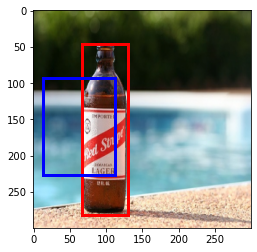

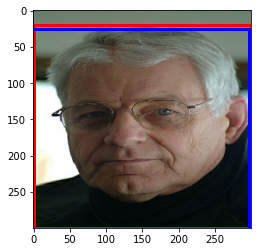

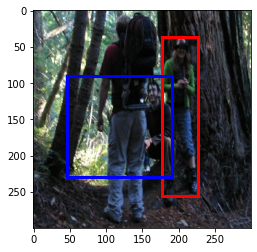

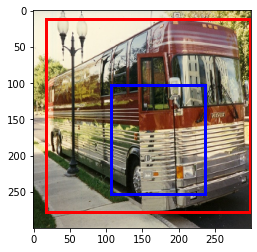

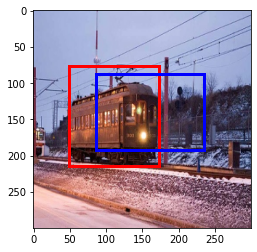

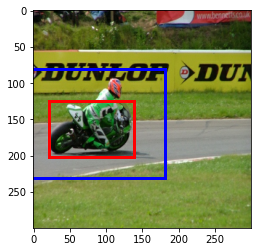

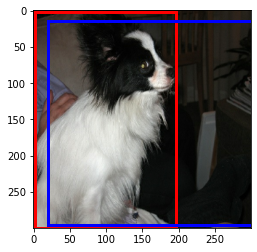

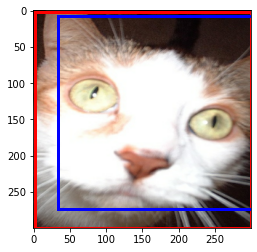

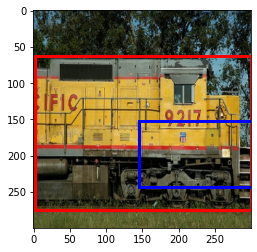

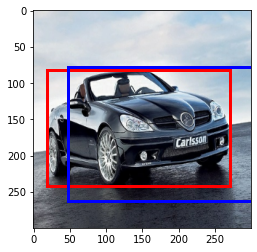

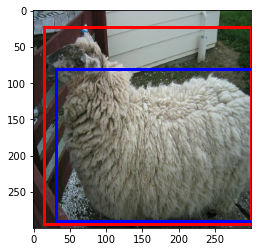

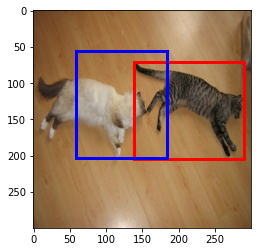

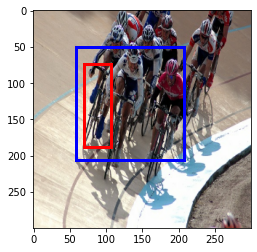

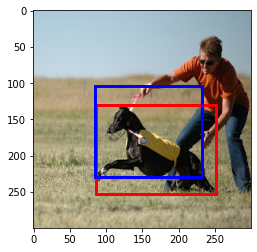

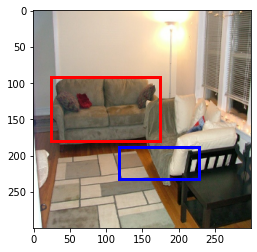

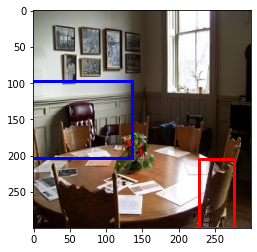

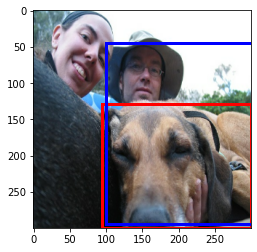

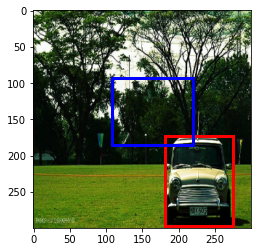

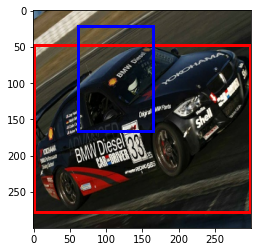

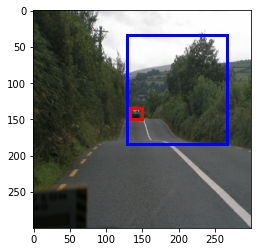

In [130]:
for t in ds_validation.take(20).map(lambda x: (tf.image.resize(x['image'], [300,300]), x['objects']['label'][0], x['objects']['bbox'][0])):  
  image_sample,label,box= t
  print(image_sample.shape, label, box)

  height = image_sample.shape[1]
  width = image_sample.shape[0]
  top_y = box[0]* width
  top_x = box[1]* height
  height_bbox = (box[2] - box[0] ) * width
  width_bbox = (box[3] - box[1]) * height

  fig,ax = plt.subplots(1)

  # imgplot = ax.imshow(tf.image.draw_bounding_boxes(img, boxes, colors)[0])
  imgplot = ax.imshow(image.array_to_img(image_sample))
  rect = patches.Rectangle((top_x,top_y),width_bbox , height_bbox  ,linewidth=3,edgecolor='r',facecolor='none')
  # Add the patch to the Axes
  ax.add_patch(rect)


  pred_result = model.predict(image_sample[np.newaxis,...])
  print(np.argmax(pred_result[0]))

  pred_box = pred_result[1][0]

  top_y = pred_box[0]* width
  top_x = pred_box[1]* height
  height_bbox = (pred_box[2] - pred_box[0] ) * width
  width_bbox = (pred_box[3] - pred_box[1]) * height
  rect2 = patches.Rectangle((top_x,top_y),width_bbox , height_bbox  ,linewidth=3,edgecolor='b',facecolor='none')
  # Add the patch to the Axes
  ax.add_patch(rect2)


<a id="s3.1"></a>
### Training & Evaluation

To train the suggested model, we usually pre-load the weights of the convolutional layers from ImageNet models (transfer learning). If we don't have a lot of labeled images of if the images are similar to imageNet, then we can freeze those weights. For parallel training of both classification and regression, we would need a loss function that includes both classification loss and regression loss (shown in the diagram below):

$$ Total \space Loss = Classification \space (Softmax) \space Loss \space + \space Regression \space (L2) \space Loss $$


<center><img src="https://drive.google.com/uc?id=1yWwGmyUTiOEoX63K7RLvABAazBkvd8fg" ></center>

<br><center>A. Rosebrock, Intersection over Union (IoU) for object detection, 2016</center>

<center><img src="https://drive.google.com/uc?id=1WDvmeZBWRK3-h2ttKD1cHCRNhEWNEiZl" ></center>
<br><center>Source: L.A. Santos, GitBooks: Artificila Intelligence</center>

## Landmark Detection

### Facial Landmarks Detection
<img src="https://cdn-images-1.medium.com/max/800/1*Kd2LNYMhDrKJUjaUPm0Qrw.png">
<a href="https://towardsdatascience.com/facial-keypoints-detection-deep-learning-737547f73515">Selfie Filters Using Deep Learning And OpenCV (Facial Landmarks Detection)</a>

<img src="https://www.learnopencv.com/wp-content/uploads/2015/10/taaz-before-after.jpg">
<a href="https://www.learnopencv.com/facial-landmark-detection/">Facial Landmark Detection</a>

### Pose Detection 

<img src="https://blog.nanonets.com/content/images/2019/04/Screen-Shot-2019-04-11-at-5.17.56-PM.png"> 
<a href="https://blog.nanonets.com/human-pose-estimation-2d-guide/">A 2019 guide to Human Pose Estimation with Deep Learning</a>

<center><img src="https://drive.google.com/uc?id=1I_FtrvaCL9Mf0rmAvzGTATpeT5bxmfqO" ></center>

<a id="s4"></a>
## Object Detection

Classification + Localization is a relatively simple task because we are assuming there is only one main object in the image and the model predicts the class and the coordinates of the bounding box around that object alone. But in the most of the applications, there are more objects in an image and we want to detect all the objects including their type (class) and their bounding boxes (images below). This is a much more challenging task comparing to localization of a single object. 

<center><img src="https://drive.google.com/uc?id=15ksOTKFoTuv4QEiWYW5wia1ldLTDsnwg" ></center>
<br><center>Source: L.A. Santos, GitBooks: Artificila Intelligence</center>

<a id="s4.1"></a>
### Sliding Window Approach

One naive method is to apply a CNN to many different crops of the image, with different sizes and different aspect ratios. CNN classifies each crop as one of the known objects or background. The following images shows how the concept of sliding window works.

<center><img src="https://drive.google.com/uc?id=1_GQQ1-0Fwk1A8-hK4SF2un1tkbubQElb" ></center>
<br><center>Source: Fei-Fei Li, J. Johnson, s. Yeung, Convolutional Neural Networks for Visual Recognition, Spring 2018</center>

But the problem is that we need to apply CNN to huge number of locations, scales, and aspect ratios, that is very computationally expensive!

<center><img src="https://drive.google.com/uc?id=1-7rE_h1xmNERK1_nJl_qBdFCujU562u_" ></center>
<br><center>Source: Fei-Fei Li, J. Johnson, s. Yeung, Convolutional Neural Networks for Visual Recognition, Spring 2018</center>

<a id="s4.8"></a>
## Single Shot Detectors

So far we discussed R-CNN methods of object detection that all use region proposals followed by a high quality classifier to classify these proposals. These methods are accurate but come at a big computational cost (low frame-rate), in other words they are not fit to be used on embedded devices and for real-time applications.

Another type of object detectors are __Single Shot Detctors__ that combine the above two tasks into one network. They use a set of pre-defined boxes to look for objects instead of having a network produce proposals. Using convolutional features maps from later layers of a network they run small CONV filters over these features maps to predict class scores and bounding box offsets.

The main idea is that instead of using prposal methods we will run a small convolutional network over the feature maps from later layers of the main CNN to predict class scores and bounding box offsets.

There are two main architecture of this type:

1. YOLO
1. SSD


<a id="s4.9"></a>
### YOLO

YOLO (You Only Look Once) was suggested by <a href="https://arxiv.org/abs/1506.02640" target="_blank">J. Redman et al.</a> as a new approach to object detection. Their base network runs at 45 frames per second with no batch processing on a Titan X
GPU and a fast version runs at more than 150 fps while keeping the accuracy competitive. 

The idea of this detector is that you run the image on a CNN model and get the detection on a single pass. First the image is resized to 448x448, then fed to the network and finally the output is filtered by a Non-max suppression algorithm.
<br><br>
<center><img src="https://drive.google.com/uc?id=12pYcJp3OAK8v3-LRQJ2YZqbKTuhoTG6L" ></center>
<br><center>Source: J. Redmon, S. Divvala, R. Girshick, A. Farhadi, You Only Look Once: Unified, Real-Time Object Detection, 2015</center>

YOLO's detection network has 24 convolutional layers followed by 2 fully connected layers. Alternating 1 × 1 convolutional layers reduce the features space from preceding layers. Convolutional layers are pre-trained on the ImageNet classification task at half the resolution (224 × 224 input image) and then double the resolution for detection.

<center><img src="https://drive.google.com/uc?id=1EjlMljFl7cY9d8nBeDp6us7Ku4M7s2lx" ></center>

<br><center>Source: J. Redmon, S. Divvala, R. Girshick, A. Farhadi, You Only Look Once: Unified, Real-Time Object Detection, 2015</center>

YOLO models detection as a regression problem. It divides the image into an S × S grid and for each grid cell predicts B bounding boxes, confidence for those boxes, and C class probabilities. These predictions are encoded as an S × S × (B ∗ 5 + C) tensor.

Each bounding box consists of 5 predictions: x, y, w, h, and confidence. The (x, y) coordinates represent the center
of the box relative to the bounds of the grid cell. The width and height are predicted relative to the whole image. Finally the confidence prediction represents the IOU between the predicted box and any ground truth box. Formally, confidence is defined as :

$$ Pr(Object) ∗ IOU^{truth}_{pred} $$ 

Each grid cell also predicts C conditional class probabilities, Pr(Classi|Object). These probabilities are conditioned
on the grid cell containing an object. Only one set of class probabilities per grid cell is predicted, regardless of the number of boxes B. At test time, the conditional class probabilities and the individual box confidence predictions are multiplied which gives class-specific confidence scores for each box:

$$ Pr(Class_i|Object) ∗ Pr(Object) ∗ IOU^{truth}_{pred} = Pr(Class_i) ∗ IOU^{truth}_{pred} $$ 


These scores encode both the probability of that class appearing in the box and how well the predicted box fits the object.

<center><img src="https://drive.google.com/uc?id=1BgGGpSjTNjdkauEkfw80DuzseAgx4pWR" ></center>

<br><center>Source: J. Redmon, S. Divvala, R. Girshick, A. Farhadi, You Only Look Once: Unified, Real-Time Object Detection, 2015</center>

For eaxmple the following image shows how the input image is divided to 7x7 grid (S = 7) and for each cell we predict 3 (B = 3) bounding boxes (One square, one portrait, and one landscape). The original Yolo was trained for 20 classes (C =20), therefore the output has a shape of 7x7x(3x5+20). 

<center><img src="https://drive.google.com/uc?id=1skCsdhHrUZeIweHdPWAXEWTfxQuVAGAs" ></center>

<br><center>Source: Fei-Fei Li, J. Johnson, s. Yeung, Convolutional Neural Networks for Visual Recognition, Spring 2018</center>

YOLO also has a multi-part loss function. This loss function takes into account the following objectives:

1. Classification (20 classes)
1. Object/No object classification
1. Bounding box coordinates (x,y,height,width) regression (4 scalars)


Each of this sub-objectives use a sum-squared error, also a factor and are used to unbalance the box coordinates and the classification objectives.

It is also important to note that:

1. The classification loss is not back propagated if the cell has no object
1. The bounding box loss with highest IOU with the ground truth is backpropagated

<br><br>

$$
\begin{aligned} \lambda_{\text {cord }} \sum_{i=0}^{S} \sum_{j=0}^{B} \mathbb{1}_{i j}^{\text {obj }}\left[\left(x_{i}-\hat{x}_{i}\right)^{2}+\left(y_{i}-\hat{y}_{i}\right)^{2}\right] \\+\lambda_{\text {coord }} \sum_{i=0}^{S^{2}} \sum_{j=0}^{B} \mathbb{1}_{i j}^{\text {obj }}\left[(\sqrt{w_{i}}-\sqrt{\hat{w}_{i}})^{2}+(\sqrt{h_{i}}-\sqrt{\hat{h}_{i}})^{2}\right] \\+\sum_{i=0}^{S^{2}} \sum_{j=0}^{B} \mathbb{1}_{i j}^{\text {obj }}\left(C_{i}-\hat{C}_{i}\right)^{2} \\+\lambda_{\text {noobj }} \sum_{i=0}^{S^{2}} \sum_{j=0}^{B} 1_{i j}^{\text {nooti }}\left(C_{i}-\hat{C}_{i}\right)^{2} \\ &+\sum_{i=0}^{S^{2}} \mathbb{1}_{i}^{\text {obj }} \sum_{c \in \text { classs }}\left(p_{i}(c)-\hat{p}_{i}(c)\right)^{2} \end{aligned}
$$


<br><center>Source: J. Redmon, S. Divvala, R. Girshick, A. Farhadi, You Only Look Once: Unified, Real-Time Object Detection, 2015</center>


<a id="s4.10"></a>
### SSD

**Single Shot MultiBox Detector** was introduced by <a href="https://arxiv.org/abs/1512.02325" target="_blank">W. Liu et al</a>. It differs from YOLO because of using multiple layers (instead of using last year) that provide a finer accuracy on objects with different scales. (Each deeper layer will see bigger objects). The following diagram comapres the two architectures. 

The base of SSD normally is a VGG or Resnet pre-trained model that is converted to a fully convolution neural network. Then some extra conv layers are attached, which will actually help to handle bigger objects. The SSD architecture can in principle be used with any deep network base model.


<br><br>
<center><img src="https://drive.google.com/uc?id=1iiBC1HJNHFWzkxsbyNHtcZBT8uAaGt47" ></center>

<br><center>Source: W. Liu, D. Anguelov, D. Erhan, C. Szegedy, S. Reed, C. Fu, A. C. Berg, SSD: Single Shot MultiBox Detector, 2015</center>

The follwoing images shows the default bounding boxes. SSD only needs an input image and ground truth boxes for each object during training. In a convolutional fashion, a small set (e.g. 4) of default boxes of different aspect ratios at each location in several feature maps with different scales (e.g. 8 × 8 and 4 × 4 in (b) and (c)) is evaluated. For each default box, both the shape offsets and the confidences for all object categories ((c1, c2, · · · , cp)) are predicted. 


At training time, first these default boxes are matched to the ground truth boxes. For example, in teh image, two default boxes with the cat and one with the dog are matched, which are treated as positives and the rest as negatives. 

<br><br>
<center><img src="https://drive.google.com/uc?id=10h8CFrJphwyIUvkzO5qGHtCFuvkjRrC1" ></center>

<br><center>Source: W. Liu, D. Anguelov, D. Erhan, C. Szegedy, S. Reed, C. Fu, A. C. Berg, SSD: Single Shot MultiBox Detector, 2015</center>

The model loss is a weighted sum between localization loss (e.g. Smooth L1) and confidence loss (e.g. Softmax): (N is the number of matched default boxes)

$$
L(x, c, l, g)=\frac{1}{N}\left(L_{c o n f}(x, c)+\alpha L_{l o c}(x, l, g)\right)
$$

<br><center>Source: W. Liu, D. Anguelov, D. Erhan, C. Szegedy, S. Reed, C. Fu, A. C. Berg, SSD: Single Shot MultiBox Detector, 2015</center>

The localization loss is a Smooth L1 loss between the predicted box ($l$) and the ground truth box ($g$) parameters. Similar to Faster R-CNN, we regress to offsets for the center ($cx$, $cy$) of the default bounding box ($d$) and for its width ($w$) and height ($h$).

$$
\begin{aligned} L_{l o c}(x, l, g)=\sum_{i \in P o s}^{N} \sum_{\{c x, c y, w, h\}} x_{i j}^{k} \text { smooth }_{\mathrm{L} 1}\left(l_{i}^{m}-\hat{g}_{j}^{m}\right) \\ \hat{g}_{j}^{c x}=\left(g_{j}^{c x}-d_{i}^{c x}\right) / d_{i}^{w} & \hat{g}_{j}^{c y}=\left(g_{j}^{c y}-d_{i}^{c y}\right) / d_{i}^{h} \\ \hat{g}_{j}^{w}=\log \left(\frac{g_{j}^{w}}{d_{i}^{w}}\right) & \hat{g}_{j}^{h}=\log \left(\frac{g_{j}^{h}}{d_{i}^{h}}\right) \end{aligned}
$$

<br><center>Source: W. Liu, D. Anguelov, D. Erhan, C. Szegedy, S. Reed, C. Fu, A. C. Berg, SSD: Single Shot MultiBox Detector, 2015</center>

The confidence loss is the softmax loss over multiple classes confidences ($c$) and the weight term $\alpha$ is set to 1 based on the result of cross validation.

$$
L_{c o n f}(x, c)=-\sum_{i \in P o s}^{N} x_{i j}^{p} \log \left(\hat{c}_{i}^{p}\right)-\sum_{i \in N e g} \log \left(\hat{c}_{i}^{0}\right) \quad \text { where } \quad \hat{c}_{i}^{p}=\frac{\exp \left(c_{i}^{p}\right)}{\sum_{p} \exp \left(c_{i}^{p}\right)}
$$

<br><center>Source: W. Liu, D. Anguelov, D. Erhan, C. Szegedy, S. Reed, C. Fu, A. C. Berg, SSD: Single Shot MultiBox Detector, 2015</center>


You can find the sample implementation [here](https://github.com/mvoelk/ssd_detectors) 

<a id="s5"></a>
## Semantic Segmentation

This is the task to label each pixel in an image with a category/class label. We don’t differentiate instances, only care about pixels. This is very different thatn object detection because we are not looking for the bounding boxes and their classes but we want to classify each pixel.

<center><img src="https://drive.google.com/uc?id=1GDZUBEGzBLdWyzZip0OWds0xj-uMz27V" ></center>

<br><center>Source: Fei-Fei Li, J. Johnson, s. Yeung, Convolutional Neural Networks for Visual Recognition, Spring 2018</center>

<a id="s5.1"></a>
### Sliding Window Approach

Similar to object detection, one naive approach is the sliding window approach. In this approach, we will extract a square patch (window) around each pixel. Then we use a CNN classifier to classify the object in the window. This class will be assigned to the corresponding pixel. It is important to note that we have to fine-tune the CNN to classify the objects from some patches of them. 

The obvious issue with this approach is lack of efficiency. We have to run as many patches as the number of pixels through a CNN. That means we are repeating the calculations for overlapping parts of the windows. 
<center><img src="https://drive.google.com/uc?id=1jH8R3Hwpm-pwoVdc9sqUVv2kzwcmJdMk" ></center>

<br><center>Source: Fei-Fei Li, J. Johnson, s. Yeung, Convolutional Neural Networks for Visual Recognition, Spring 2018</center>

<a id="s5.2"></a>
### Fully Convolutional Networks (FCN) for Semantic Segmentation

One idea to fix the inefficiency of the sliding window method is to use one fully convolutional network to map from the input image to a segmented image as the output. The following diagram shows the idea. However, convolutions at original image resolution will be very expensive. In regular CNNs the resolution is reduced as it goes deeper in the network.  

<center><img src="https://drive.google.com/uc?id=1R1SaOK1-1FJCFWUrDo54-pg0Akagld1-" ></center>

<br><center>Source: Fei-Fei Li, J. Johnson, s. Yeung, Convolutional Neural Networks for Visual Recognition, Spring 2018</center>

<a href="https://arxiv.org/abs/1411.4038" target="_blank">J. Long et al.</a> introduces a fully convolutional network (FCN) to fix the above issue. FCN is a normal CNN, where the last fully connected layer is substituted by another convolution layer with a large "receptive field". FCN adapts and extends deep classification architectures, using image classification as supervised pre-training, and fine-tune fully convolutionally to learn simply and efficiently from whole image inputs and whole image ground thruths. 

The course outputs of the classifier CNN (e.g. AlexNet) is connected to dense pixels thruugh interpolation a.k.a. upsampling. A natural way to upsample is backwards convolution (sometimes called deconvolution wrongly). 

Here are the steps to convert a CNN classifier to FCN (for Pascal classes):

1. We begin by a convolutionalizing proven classification architecture like AlexNet, VGG, GoogLeNet, and so on.
1. We decapitate each net by discarding the final classifier layer, and convert all fully connected layers to convolutions. 
1. We append a 1 × 1 convolution with channel dimension 21 to predict scores for each of the PASCAL classes (including background) at each of the coarse output locations, followed by a backward convolution layer to bilinearly upsample the coarse outputs to pixel-dense outputs. 

<center><img src="https://drive.google.com/uc?id=1tKzvoTpCZ3DRP19RH8RVvzUI1NXg_F6h" ></center>
<br><center>Source: J. Long, E. Shelhamer, T. Darrell, Fully Convolutional Networks for Semantic Segmentation, 2015</center>

The suggested FCN worked reasonably but having one backward convolutional layer on top of CNN seemed to be inadequate. Therefore, <a href="https://arxiv.org/abs/1505.04366" target="_blank">H. Noh et al.</a> suggested to learn d full backward convolutional network (deconvolutional network) on top of the convolutional layers adopted from VGG 16-layer net. The deconvolution network is composed of deconvolution and unpooling layers, which identify pixel-wise class labels and predict segmentation masks. Given a feature representation obtained from the convolution network, dense pixel-wise class prediction map is constructed through multiple series of unpooling, deconvolution and rectification operations.


<center><img src="https://drive.google.com/uc?id=1BGE0whBnfoRqfOcqf2RMxIspyZY75Qx_" ></center>

<br><center>Source: H. Noh, S. Hong, B. Han, Learning Deconvolution Network for Semantic Segmentation, 2015</center>

#### Unpooling & Deconvolution

Pooling in convolution network is designed to filter noisy activations in a lower layer by abstracting activations in a receptive field with a single representative value. Although it helps classification by retaining only robust activations in upper layers, spatial information within a receptive field is lost during pooling, which may be critical for precise localization that is required for semantic segmentation. To resolve such issue, unpooling layers in deconvolution network are employed, which perform the reverse operation of pooling and reconstruct the original size of activations as illustrated in image below.

The output of an unpooling layer is an enlarged, yet sparse activation map. The deconvolution layers densify the sparse activations obtained by unpooling through convolution-like operations with multiple learned filters. However, contrary to convolutional layers, which connect multiple input activations within a filter window to a single activation, deconvolutional layers associate a single input activation with multiple outputs, as also illustrated in image below. 

<center><img src="https://drive.google.com/uc?id=17OUSAlNDPITzvE4wF_2FffqtLsKDTFKV" ></center>

<br><center>Source: H. Noh, S. Hong, B. Han, Learning Deconvolution Network for Semantic Segmentation, 2015</center>

To understand it better, the following image shows an example of how deconvolution (upsampling) for 1D tensor works. It works the same way for 2D tansors.

<center><img src="https://drive.google.com/uc?id=1pJVdOm8vVrsFAi9dQOfEpeK6Pbi2BQTU" ></center>
<br><center>Source: Fei-Fei Li, J. Johnson, s. Yeung, Convolutional Neural Networks for Visual Recognition, Spring 2018</center>

#### Training 

The new network is very deep (almost twice deeper than FCN) and contains a lot of associated parameters. In addition, the number of training examples for semantic segmentation is relatively small compared to the size of the network (12031 PASCAL training and validation images in total). Training a deep network with a limited number of examples is not trivial but it was done using some ideas including batch normalization and two-stage training. The training is done first with easy examples and fine-tuned with more challenging examples later. To construct training examples for the first stage training, the object instances are cropped using ground-truth annotations so that an object is centered at the cropped bounding box


#### Comparison

The following image comapres the results of this new network and FCN. It shows how the results are improved.
<center><img src="https://drive.google.com/uc?id=1FH6F_7lKe1pCRiuj0d2NLHOIsC8ooPOC" ></center>

<br><center>Source: H. Noh, S. Hong, B. Han, Learning Deconvolution Network for Semantic Segmentation, 2015</center>

<a id="s5.3"></a>
### U-Net

One practical use of semantivc segmentation is in Biomedical Image Segmentation. <a href="https://arxiv.org/abs/1505.04597" target="_target">U-Net</a> is a convolutional network for the same purpose that is using similar convolution-deconvolution (a.k.a. encoder-decoder) architecture. The following digram shows the architecture of the newtork:

<center><img src="https://drive.google.com/uc?id=1GbLBV9hY_2oImClFtW51INT-2vQA8aai" ></center>
<br><center>Source: O. Ronneberger, P. Fischer, T. Brox, U-Net: Convolutional Networks for Biomedical Image Segmentation, 2015</center>

The following image shows two samples of biomedical image segmented using U-Net: 

<center><img src="https://drive.google.com/uc?id=1qPbnxkes3mn4kfx8ZL2-OQPFcPCfKMrq" ></center>

<br><center>Source: O. Ronneberger, P. Fischer, T. Brox, U-Net: Convolutional Networks for Biomedical Image Segmentation, 2015</center>

# Instance Segmentation Demo

Following download necessary libraries.

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-o7rmrpuq
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-o7rmrpuq
  Created wheel for tensorflow-examples: filename=tensorflow_examples-3732c644f0f3841225726f755bd79514d2ca69fa_-cp37-none-any.whl size=265248 sha256=a66a9e18ab93dd9a35f1bfbc49a6fb21be966e1340417ce5f389a3153512438d
  Stored in directory: /tmp/pip-ephem-wheel-cache-ycd8ygfb/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples


In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

# from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

## Download the Oxford-IIIT Pets dataset

The dataset is already included in TensorFlow datasets, all that is needed to do is download it. The segmentation masks are included in version 3.0.0, which is why this particular version is used.

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.2.0', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete7RVNUA/oxford_iiit_pet-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete7RVNUA/oxford_iiit_pet-test.tfrecord
Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [ ]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

The dataset already contains the required splits of test and train and so let's continue to use the same split.

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 128
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [ ]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

Let's take a look at an image example and it's correponding mask from the dataset.

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

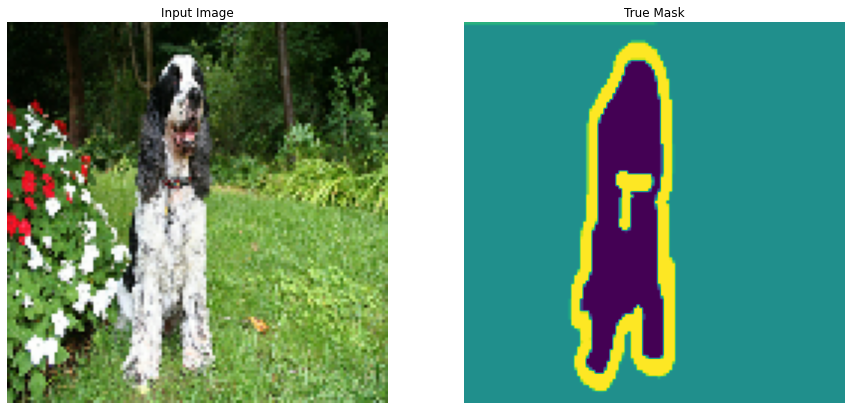

In [ ]:
for image, mask in train.take(2):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [ ]:
from tensorflow import keras
from keras import layers
inputs = keras.layers.Input(shape=(128,128,3), name="inputs")

down_sample_layer_conv_1 = keras.layers.Conv2D(15, 7, name="down_sample_layer_conv_1",  strides=1,
                                               padding="same", use_bias=False, kernel_initializer='lecun_uniform', activation="selu")(inputs)
down_sample_layer_pool_1 = keras.layers.MaxPool2D( 2, name="down_sample_layer_pool_1", strides=2)(down_sample_layer_conv_1)


down_sample_layer_conv_2 = keras.layers.Conv2D(30, 7, name="down_sample_layer_conv_2",  strides=1, padding="same", use_bias=False,
                                               kernel_initializer='lecun_uniform', activation="selu")(down_sample_layer_pool_1)
down_sample_layer_pool_2 = keras.layers.MaxPool2D(2, name="down_sample_layer_pool_2", strides=2)(down_sample_layer_conv_2)


down_sample_layer_conv_3 = keras.layers.Conv2D(45, 7, name="down_sample_layer_conv_3", strides=1, padding="same", use_bias=False, 
                                               kernel_initializer='lecun_uniform', activation="selu")(down_sample_layer_pool_2)
down_sample_layer_pool_3 = keras.layers.MaxPool2D(2, name="down_sample_layer_pool_3",  strides=2)(down_sample_layer_conv_3)





up_sample_layer_convt_1 = tf.keras.layers.Conv2DTranspose(name ="up_sample_layer_convt_1", filters=45, kernel_size=3, strides=1, padding='same', 
                                                          kernel_initializer='lecun_uniform', activation="selu",
                                                          use_bias=False)(down_sample_layer_pool_3)
up_sample_layer_upool_1 = tf.keras.layers.UpSampling2D(name="up_sample_layer_upool_1", 
                                                       size=(2, 2))(up_sample_layer_convt_1)

concat = tf.keras.layers.Concatenate()

up_sample_layer_upool_1_concated = concat([up_sample_layer_upool_1, down_sample_layer_conv_3])


up_sample_layer_convt_2 = tf.keras.layers.Conv2DTranspose(name="up_sample_layer_convt_2", filters=30, kernel_size=3, strides=1, padding='same', 
                                                          kernel_initializer='lecun_uniform', activation="selu",
                                                          use_bias=False)(up_sample_layer_upool_1_concated)
up_sample_layer_upool_2 = tf.keras.layers.UpSampling2D(name="up_sample_layer_upool_2",size=(2, 2))(up_sample_layer_convt_2 )

up_sample_layer_upool_2_concated = concat([up_sample_layer_upool_2, down_sample_layer_conv_2])

up_sample_layer_convt_3 = tf.keras.layers.Conv2DTranspose(name="up_sample_layer_convt_3", filters=15, kernel_size=3, strides=1, padding='same', 
                                                          kernel_initializer='lecun_uniform', activation="selu",
                                                          use_bias=False)(up_sample_layer_upool_2_concated)

up_sample_layer_upool_3 = tf.keras.layers.UpSampling2D(name="up_sample_layer_upool_3", size=(2, 2))(up_sample_layer_convt_3)


up_sample_layer_upool_3_concated = concat([up_sample_layer_upool_3, down_sample_layer_conv_1])

up_sample_layer_convt_4 = tf.keras.layers.Conv2DTranspose(filters=3, name="outputs", kernel_size=3, padding="same", strides=1,  activation='softmax')(up_sample_layer_upool_3_concated)

outputs = up_sample_layer_convt_4

model = keras.Model(inputs=inputs, outputs=outputs)
print(model.summary())


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
down_sample_layer_conv_1 (Conv2 (None, 128, 128, 15) 2205        inputs[0][0]                     
__________________________________________________________________________________________________
down_sample_layer_pool_1 (MaxPo (None, 64, 64, 15)   0           down_sample_layer_conv_1[0][0]   
__________________________________________________________________________________________________
down_sample_layer_conv_2 (Conv2 (None, 64, 64, 30)   22050       down_sample_layer_pool_1[0][0]   
______________________________________________________________________________________________

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
EPOCHS = 100
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset
                         )

Epoch 1/100
28/28 [==============================] - 47s 345ms/step - loss: 1.6199 - accuracy: 0.5048 - val_loss: 0.8775 - val_accuracy: 0.6059
Epoch 2/100
28/28 [==============================] - 7s 203ms/step - loss: 0.8322 - accuracy: 0.6148 - val_loss: 0.8249 - val_accuracy: 0.6228
Epoch 3/100
28/28 [==============================] - 6s 201ms/step - loss: 0.7958 - accuracy: 0.6364 - val_loss: 0.7988 - val_accuracy: 0.6539
Epoch 4/100
28/28 [==============================] - 6s 203ms/step - loss: 0.7755 - accuracy: 0.6538 - val_loss: 0.7769 - val_accuracy: 0.6635
Epoch 5/100
28/28 [==============================] - 6s 203ms/step - loss: 0.7596 - accuracy: 0.6704 - val_loss: 0.7560 - val_accuracy: 0.6767
Epoch 6/100
28/28 [==============================] - 6s 204ms/step - loss: 0.7435 - accuracy: 0.6768 - val_loss: 0.7426 - val_accuracy: 0.6847
Epoch 7/100
28/28 [==============================] - 6s 206ms/step - loss: 0.7292 - accuracy: 0.6894 - val_loss: 0.7422 - val_accuracy: 0.683

Let's try out the model to see what it predicts before training.

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

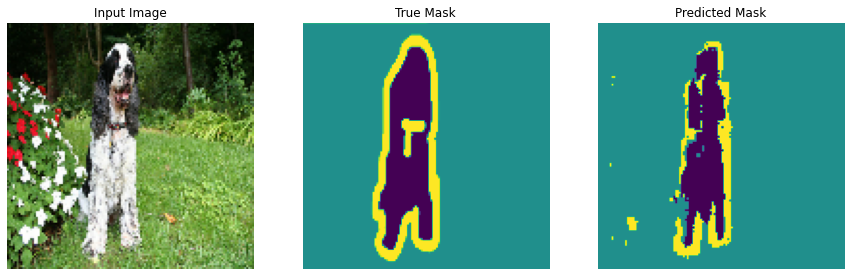

In [ ]:
show_predictions()

Let's observe how the model improves while it is training. To accomplish this task, a callback function is defined below. 

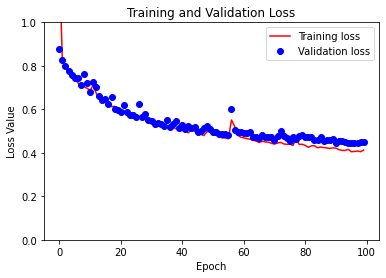

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Make predictions

Let's make some predictions. In the interest of saving time, the number of epochs was kept small, but you may set this higher to achieve more accurate results.

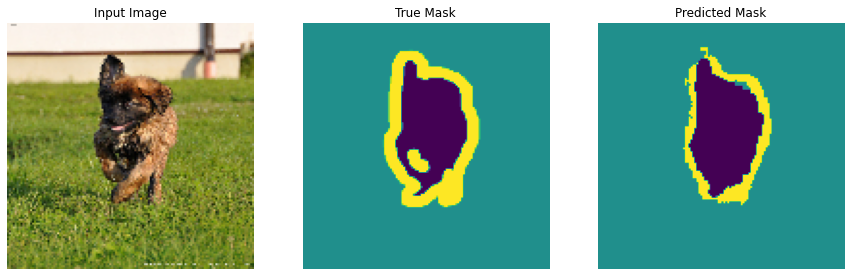

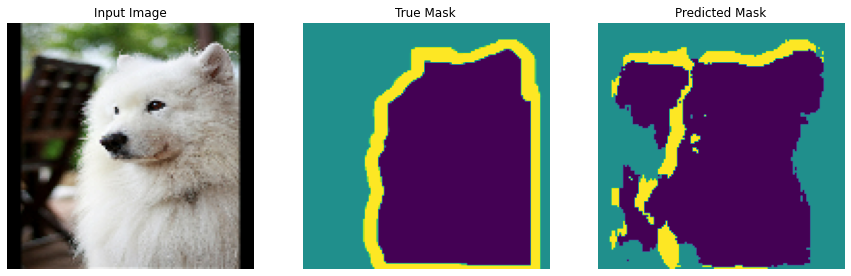

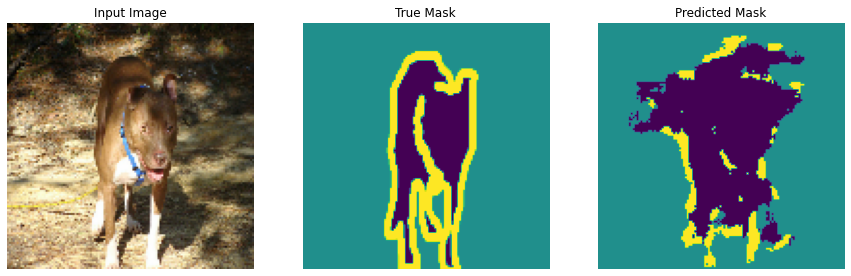

In [ ]:
show_predictions(test_dataset, 3)

<a id="s5.4"></a>
### Real-time Semantic Segmentation

Semantic segmentation is used in many applications e.g. automatic driving, robotic interaction, online video processing, and even mobile computing where running time becomes a critical factor. Therefore, fast or real-time semantic segmentation is increasingly becomeing important. 

There are many models for semenatic segmentation, that some of them we have reviewed in this lecture. But not all of them are approperiate for real-time applications. The following diagram comapres the accuarcy vs. speed of the  existing models.

<center><img src="https://drive.google.com/uc?id=1P4iAexvKO2iDoje-fnPNXSjOvVx6y_3H" ></center>

<br><center>Source: H. Zhao, X. Qi, X. Shen, J. Shi, J. Jia, ICNet for Real-Time Semantic Segmentation on High-Resolution Images, 2017</center>

As shown in the diagram, <a href="https://arxiv.org/abs/1704.08545" target="_blank">ICNet (Image Cascade Network)</a> offers the best trade-off between accuracy and speed and is good for real-time applications. ICNet adopts intuitive speedup strategies including downsampling input, shrinking feature maps and conducting model compression.

Segmenting the high-resolution input with classical frameworks like FCN directly is time consuming. However, downsampling the input results in very coarse prediction maps. To overcome this shortcoming, ICNet gets semantic extraction a using low-resolution input as shown in the diagram below. A $\frac{1}{4}$ sized image is fed into PSPNet (a very accurate but slow model) with downsampling rate 8, resulting in a $\frac{1}{32}$-resolution feature map. To get high quality segmentation, medium and high resolution branches (middle and bottom parts in diagram) help recover and refine the coarse prediction. Though some details are missing and blurry boundaries are generated in the top branch, it already harvests most semantic parts. Thus we can safely limit the number of parameters in both middle and bottom branches. Light weighted CNNs (green dotted box) are adopted in higher resolution branches; different-branch output feature maps are fused by cascade-feature-fusion (CFF) unit and trained with cascade label guidance (CLG). For more details about CFF and CLG, refer to the ooriginal paper <a href="https://arxiv.org/abs/1704.08545" target="_blank">here</a>.  


<center><img src="https://drive.google.com/uc?id=1Fpt19AJl1NebXri17XHi-y02gX9Re7EA" ></center>
<br><center>Source: H. Zhao, X. Qi, X. Shen, J. Shi, J. Jia, ICNet for Real-Time Semantic Segmentation on High-Resolution Images, 2017</center>

<a id="s4.2"></a>
# Region Proposals (Detection, Instance Segmentation)

One way to solve the above problem is to find a way to estimate the image regions that are likely to contain objects (a.k.a. __Region Proposals__). An important property of a region proposal method is to have a very high recall. This means that the regions that contain the objects we are looking have to be in our list of region proposals (very low false negative).

Several region proposal methods have been proposed but __Selective Search__ is most commonly used because it is fast and has a very high recall. It is designed to be fast (gives 2000 region proposals in a few seconds on CPU) with a very high recall. It is based on computing hierarchical grouping of similar regions based on color, texture, size and shape compatibility.

We will not discuss the details of this algorithm because the recent state-of-the-arts models are not using search methods anymore. For more information, you can read <a href="https://www.learnopencv.com/selective-search-for-object-detection-cpp-python/" target="_blank">this blog</a>.

<a id="s4.3"></a>
### R-CNN

R-CNN, that stands for Regions and CNN Features, is a model that was suggested by <a href="https://arxiv.org/abs/1311.2524" target="_blank">Girshick et al</a>. 

Object detection in R-CNN is done in the following steps:

1. Take a pre-trained ImageNet CNN (e.g. AlexNet)

2. Re-train the last fully connected layer with the objects that need to be detected + "no-object" class

3. Find the __Regions of Interests (ROI)__ using Selective Search (Region Proposals) and save them on a disk

4. Train a SVM to classify between object and background (One binary SVM for each class)

5. Train a linear regression model (Bounding-Box Regressor) that will output bounding box offsets (comparing to the proposed region)

<center><img src="https://drive.google.com/uc?id=1rG1wPptzsUHrgA1340KuTBI2Z06g7Siu" ></center>

<br><center>Source: Fei-Fei Li, J. Johnson, s. Yeung, Convolutional Neural Networks for Visual Recognition, Spring 2018</center>

R-CNN is a good step forward toward more efficient object detection but it has the following problems:

1. It is has a ad-hoc training process:
    1. Fine-tune network with softmax classifier (log loss)
    1.Train post-hoc linear SVMs (hinge loss)
    1. Train post-hoc bounding-box regressions (least squares)
1. Training is very slow (long hours > 80H) and takes a lot of disk space
1. Inference (detection) is slow too because of two main reasons:
    1. Search region proposals takes a coupls of seconds 
    1. Running all 2000 regions through the entire CNN will take tens of seconds. 

Because the inference is slow this method is not appropriate for real-time (video) applications. 

<a id="s4.4"></a>
### Fast R-CNN

One major issue with R-CNN was the speed due to the fact that around 2000 images crops had to go through an entire CNN. The creators of R-CNN suggested another model to solve this problem. The idea of <a href="https://arxiv.org/abs/1504.08083" target="_blank">Fast R-CNN</a> is that instead of applying all ROIs to a CNN, we apply the whole image to the CNN once and then find the ROIs on the feature map of the image. Fast R-CNN still uses Selective search method to find ROIs but it does it on the output of the CNN. 
<center><img src="https://drive.google.com/uc?id=1YEWILsZWKgw2yNf_Mrglc4OCcwvSAKPu" ></center>

<br><center>Source: Fei-Fei Li, J. Johnson, s. Yeung, Convolutional Neural Networks for Visual Recognition, Spring 2018</center>

#### ROI Pooling

Similar to RCNN, the ROIS have different sizes and need to be resized. But becuase the resolution of the featur map is a lot less than the original image we will use a pooling mthod called __ROI Pooling__. The output of ROI pooling will go through a fully connected layer and then a softmax classifier and a linear regressor for bounding boxes offsets. 

ROI pooling layer divides each projected proposal into a 7x7 grid and then max-pool within each cell.

<center><img src="https://drive.google.com/uc?id=1ADD-aNjI6ODI8NW8ZsF6FRzw43cmDAeF" ></center>

<br><center>Source: Fei-Fei Li, J. Johnson, s. Yeung, Convolutional Neural Networks for Visual Recognition, Spring 2018</center>

#### Training

Fast R-CNN is using a multi-task loss function for training. The CNN weights are initialized from a pre-trained ImageNet classifier except the last fully connected layers that are replaced with two parallel networks for classification and bounding-box regression. 

The loss function is made of two parts:

1. Log of a softmax loss for class prediction
1. Smooth L1 loss for linear regression of bounding box offsets


$$ L(p, c, \Delta^c, v) =  L_{cls}(p, c) + \lambda [c \ge 1] L_{reg}(\Delta^c, v) $$

$$ L_{cls}(p, c) = -log(p_c) $$

$$ L_{reg}(\Delta^c, v) = \sum_{i \in \{x, y, w, h\}} Smooth_{L_1}(\Delta^c_i - v_i) $$

$$ Smooth_{L_1}(x) = \left\{\begin{matrix}
0.5x^2 & if \space | x | < 1\\ 
| x | - 05 & otherwise
\end{matrix}\right. $$


| Symbol | Definition |
|--------------------|--------------------------------|
| $c$ | Ground truth class |
| $v$ | Ground truth bunding-box coordinates |
| $\Delta^c = \\ (\Delta_x^c, \Delta_y^c, \Delta_w^c, \Delta_h^c)$ | Bounding-box offsets |
| $p = (p_0, \dots, p_C)$ | Softmax probabilities for C+1 classes |


<center><img src="https://drive.google.com/uc?id=1blTeust6xSmN15t0IiGJG-lf-7vF-mnZ" ></center>

<br><center>Source: Fei-Fei Li, J. Johnson, s. Yeung, Convolutional Neural Networks for Visual Recognition, Spring 2018</center>

<a id="s4.5"></a>
### Faster R-CNN 

Fast R-CNN made a lot of improvement in terms of speed and accuracy of the object detection but it is still relying on traditional region proposal methods. <a href="https://arxiv.org/abs/1506.01497" target="_blank">S. Ren, K. He, R. Girshick, and J. Sun</a> suggested an improved version called Faster R-CNN. 

They introduced a __Region Proposal Network (RPN)__ to predict proposal from the feature map. That eliminates the need for using traditional proposal search method and speeds up the deection because we can use GPU for that.

During the trainig, it learns everything together by minimizing all following four losses jointly:

1. RPN classify object / not object
1. RPN regress box coordinates
1. Final classification score (object classes)
1. Final box coordinates


<center><img src="https://drive.google.com/uc?id=1vCJZlltIDJrswPYgBjWTKEh7YDfMoy3X" ></center>

<br><center>Source: Ren et al, “Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks”, NIPS 2015</center>

#### Complete Structure

The following diagram shows the complete structure of Faster R-CNN:
<br><br>
<center><img src="https://drive.google.com/uc?id=1UpQDZX1Q_ZeAdhGnQ1z35jtJYz8pWQjJ" ></center>

<br><center>Source: L.A. Santos, GitBooks: Artificial Intelligence</center>

#### Speed comparison

The following diagram compares the inference speed of different object detections we discussed so far (we didn't disus SPP-Net). It shows how much it is improved from R-CNN t Faster R-CNN.

<center><img src="https://drive.google.com/uc?id=1a2qrSPF1P1TQyr4UeoY4YFruoO1ZtNVl" ></center>

<br><center>Source: Fei-Fei Li, J. Johnson, s. Yeung, Convolutional Neural Networks for Visual Recognition, Spring 2018</center>

<a id="s4.6"></a>
### Mask R-CNN (Object Detection + Instance Segmentation)

__Instance Segmentation__ is an extension of object detection, that associates a binary mask (1 = object, 0 = background) with every bounding box.

<a href="https://arxiv.org/abs/1703.06870" target="_blank">Mask R-CNN</a> ia a simple, flexible, and general framework for object instance segmentation. It extends Faster R-CNN by adding a branch for predicting an object mask in parallel with the existing branch for bounding box recognition. Mask R-CNN is simple to train and adds only a small overhead to Faster R-CNN, running at 5 fps. Moreover, Mask R-CNN is easy to generalize to other tasks, e.g., allowing us to estimate human poses in the same framework.
<center><img src="https://drive.google.com/uc?id=1VTeS2LmmssIPKRcAI02nGbpRVzczcXjs" ></center>

<br><center>Source: K. He, G. Gkioxari, P. Dollar, R. Girshick, Mask R-CNN, 2017</center>

#### ROIAlign

Mask R-CNN adopts the same two-stage procedure, with an identical first stage (which is RPN). In the second stage, in parallel to predicting the class and box offset, Mask R-CNN also outputs a binary mask for each RoI. However,  constructing the mask branch properly is critical for good results. Most importantly, Faster RCNN was not designed for pixel-to-pixel alignment between network inputs and outputs. This is most evident in how RoIPool performs coarse spatial quantization for feature extraction. To fix the misalignment, Mask R-CNN uses a simple, quantization-free layer, called __RoIAlign__, that faithfully preserves exact spatial locations. 

RoIPool first quantizes a floating-number RoI to the discrete granularity of the feature map, this quantized RoI is then subdivided into spatial bins which are themselves quantized, and finally feature values covered by each bin are aggregated (usually by max pooling). RoIAlign layer removes the harsh quantization of RoIPool, properly aligning the extracted features with the input. It avoids any quantization of the RoI boundaries or bins and uses bilinear
interpolation to compute the exact values of the input features at four regularly sampled locations in each
RoI bin, and aggregate the result (using max or average). The following images demostrated the difference bwtweem ROIPool and ROIAlign. 
<center><img src="https://drive.google.com/uc?id=1dGOliUq5l7Biog-UWoDAPYdvu0ZH9RKS" ></center>


<center><img src="https://drive.google.com/uc?id=1oLug2vzpu4HQC-C3LGv-VQ9pjlalS1QV" ></center>


#### Loss Function

Mask R-CNN uses a multi-task loss on each sampled RoI as below:

$$ L = L_{cls} + L_{box} + L_{mask} $$

The classification loss $L_{cls}$ and bounding-box loss $L_{box}$ are identical as those defined in Faster R-CNN. 

The mask branch has a $Km^2$ dimensional output for each RoI, which encodes $K$ binary masks of resolution m × m, one for each of the $K$ classes. A per-pixel sigmoid is applied, and $L_{mask}$ is defined as the average binary cross-entropy loss. For an RoI associated with ground-truth class $k$, $L_{mask}$ is only defined on the $k^{th}$ mask (other mask outputs do not contribute to the loss). The definition of $L_{mask}$ allows the network to generate masks for every class without competition among classes.

#### Results

The results of Mask R-CNN are very good (on COCO dataset) as shown in the image below. These results are based on ResNet-101, achieving a mask AP of 35.7 and running at 5 fps. Masks are shown in color, and bounding box, category, and confidences are also shown.

<center><img src="https://drive.google.com/uc?id=1HZzV8PE--kKQitv79IikkBh_2pRHNbJV" ></center>

<br><center>Source: K. He, G. Gkioxari, P. Dollar, R. Girshick, Mask R-CNN, 2017</center>

#### Human Pose Estimation

Humen pose estimation is a set of techniques in computer vision with the purpose of detecting human figures in images and/or videos. For example, one can determine where someone’s elbow or arm shows up in an image.

Mask R-CNN can easily be extended to human pose estimation. It models a keypoint’s location as a one-hot mask, and adopt Mask R-CNN to predict $K$ masks, one for each of $K$ keypoint types (e.g., left shoulder, right elbow).

<center><img src="https://drive.google.com/uc?id=1j_f0gyKDmLSqxMHT7QyaOhO_3vPfWzoQ" ></center>

<br><center>Source: K. He, G. Gkioxari, P. Dollar, R. Girshick, Mask R-CNN, 2017</center>

<a id="s4.11"></a>
### Speed / Accuracy Comparison of Object Detectors

A paper from <a href="https://arxiv.org/abs/1611.10012" target="_blank">Google Research</a> is comparing speed/accuracy trade-offs for modern convolutional object detectors. The following diagram summerizes their finding. We can see that models with Regional Proposal Networks (e.g. Faster R-CNN) have the potential for higher accuracy, especially using more complex CNN and higher number of box proposals, but in expense of speed. Single shot detectors are much faster but have lower accuracy, especially for small objects. This is still an active area of research and both type of deectors are being improved in both accuracy and speed.   

<center><img src="https://drive.google.com/uc?id=1HZ1S4GJRiCJh1Ceeccws-eK_ioNSfCg8" ></center>

<br><center>Source: J. Huang, V. Rathod, C. Sun, M. Zhu, A. Korattikara, A. Fathi, I. Fischer, Z. Wojna, Y. Song, S. Guadarrama, K. Murphy, Speed/accuracy trade-offs for modern convolutional object detectors, 2017</center>

<a id="s4.12"></a>
### Impact of Deep Learning on Object Detection

The following digram shows the impact of deep learning on teh task of detection object in images. It is reporting the best accuracy achived on <a href="http://host.robots.ox.ac.uk/pascal/VOC/" target="_blank">Pascal VOC</a> by year. Before 2013 (the introduction of deep learning for object detection), we can see there is a plateau but after 2013 there is an exponeential increase in accuracy.   

<center><img src="https://drive.google.com/uc?id=1zMB_LFPFLA9U1uAxecJIdy9aN9SF4ZKk" ></center>

<br><center>Source: Fei-Fei Li, J. Johnson, s. Yeung, Convolutional Neural Networks for Visual Recognition, Spring 2018</center>

<a id="s4.13"></a>
### Tensorflow Object Detection API

The <a href="https://github.com/tensorflow/models/tree/master/research/object_detection" target="_blank">TensorFlow Object Detection API</a> is an open source framework built on top of TensorFlow that makes it easy to construct, train and deploy object detection models.

<a id="s6"></a>
## Next week

Recurrent Neural Networks

<a id="s7"></a>
## Resources

- [Region Based CNN](https://d2l.ai/chapter_computer-vision/rcnn.html)

- [Instance Segmentation](https://tjmachinelearning.com/lectures/1718/instance/instance.pdf)

- <a href="https://en.wikipedia.org/wiki/Computer_vision" target="_blank">Wikipedia, Computer Vision</a>

- <a href="http://cs231n.stanford.edu/" target="_blank">Fei-Fei Li, J. Johnson, s. Yeung, Convolutional Neural Networks for Visual Recognition, Spring 2018</a>

- <a href="https://leonardoaraujosantos.gitbooks.io/artificial-inteligence" target="_blank">L.A. Santos, GitBooks: Artificial Intelligence</a>

- <a href="https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/" target="_blank">A. Rosebrock, Intersection over Union (IoU) for object detection, 2016</a>

- <a href="https://arxiv.org/abs/1611.10012" target="_blank">J. Huang, V. Rathod, C. Sun, M. Zhu, A. Korattikara, A. Fathi, I. Fischer, Z. Wojna, Y. Song, S. Guadarrama, K. Murphy, Speed/accuracy trade-offs for modern convolutional object detectors, 2017</a> 

- <a href="https://www.learnopencv.com/selective-search-for-object-detection-cpp-python/" target="_blank">V. Singh, Selective Search for Object Detection, 2017</a> 

- <a href="https://arxiv.org/abs/1311.2524" target="_blank">R. Girshick, J. Donahue, T. Darrell, J. Malik, Rich feature hierarchies for accurate object detection and semantic segmentation, 2014</a>

- <a href="https://arxiv.org/abs/1504.08083" target="_blank">R. Girshick, Fast R-CNN, 2015</a> 

- <a href="https://arxiv.org/abs/1506.01497" target="_blank">S. Ren, K. He, R. Girshick, J. Sun, Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks, 2015</a> 

- <a href="https://arxiv.org/abs/1506.02640" target="_blank">J. Redmon, S. Divvala, R. Girshick, A. Farhadi, You Only Look Once: Unified, Real-Time Object Detection, 2015</a>

- <a href="https://arxiv.org/abs/1512.02325" target="_blank">W. Liu, D. Anguelov, D. Erhan, C. Szegedy, S. Reed, C. Fu, A. C. Berg, SSD: Single Shot MultiBox Detector, 2015</a>

- <a href="https://arxiv.org/abs/1411.4038" target="_blank">J. Long, E. Shelhamer, T. Darrell, Fully Convolutional Networks for Semantic Segmentation, 2015</a>

- <a href="https://arxiv.org/abs/1505.04366" target="_blank">H. Noh, S. Hong, B. Han, Learning Deconvolution Network for Semantic Segmentation, 2015</a>

- <a href="https://arxiv.org/abs/1703.06870" target="_blank">K. He, G. Gkioxari, P. Dollár, R. Girshick, Mask R-CNN, 2017</a>

- <a href="https://arxiv.org/abs/1505.04597" target="_blank">O. Ronneberger, P. Fischer, T. Brox, U-Net: Convolutional Networks for Biomedical Image Segmentation, 2015</a>

- <a href="https://arxiv.org/abs/1704.08545" target="_blank">H. Zhao, X. Qi, X. Shen, J. Shi, J. Jia, ICNet for Real-Time Semantic Segmentation on High-Resolution Images, 2017</a>

- <a href="https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb" target="_blank">Tensorflow Object Detection Demo</a> 